# Praktikum 1

## Percobaan 1

Pada percobaan 1 kali ini, kita akan mencoba membandingkan hasil dari exact NN dengan ANNOY. data yang kita buat adalah data random 2D, dengan 1000 data point, mencari 3 data terdekat dari query point, Metric Similarity menggunakan Euclidean, dengan 3 tree Annoy.

Instalasi Annoy dulu untuk langkah awal.

In [5]:
%pip install annoy

Note: you may need to restart the kernel to use updated packages.


Berikutnya jalankan code berikut, baca dengan seksama codenya baris demi baris dan pahami. lakukan beberapa kali percobaan dan perhatikan juga hasilnya. catat hasilnya jika menggunakan jumlah tree yang berbeda.

Exact NN index: [219 898 593]
Exact NN jarak: [0.         1.36915938 2.27931544]
Waktu Exact: 7.6387 ms

Annoy NN index: [219, 898, 593]
Annoy NN jarak: [np.float64(0.0), np.float64(1.369159376273702), np.float64(2.2793154441691197)]
Waktu Annoy: 0.8237 ms


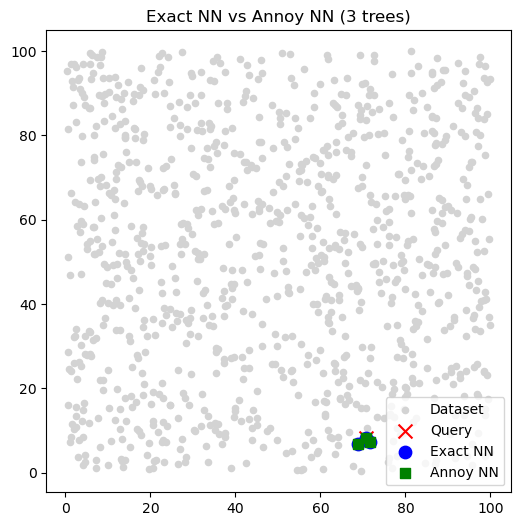

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

# 1. Dataset 2D
np.random.seed(42)
n_points = 1000
X = np.random.rand(n_points, 2) * 100  # titik random dalam ruang 100x100

# Query point (ambil salah satu titik random)
query = X[np.random.randint(0, n_points)]

# 2. Exact NN (brute force)
start = time.time()
distances = np.linalg.norm(X - query, axis=1)
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak:", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

# 3. Annoy NN (3 tree)
f = 2  # dimensi
t = AnnoyIndex(f, 'euclidean')
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # cari 3 NN
time_ann = time.time() - start

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak:", [np.linalg.norm(X[i]-query) for i in idx_ann])
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")

# 4. Visualisasi hasil
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees)")
plt.show()

Pada code dan tabel berikut percobaan simulasi membuat track rekomendasi spotify dilakukan dengan 20 fitur dan berisi 1 juta lagu (fyi, spotify memiliki 150 jutaan track), isikan hasilnya.

### Tabel eksperimen: Exact NN vs ANNOY

Isi tabel berikut dengan menjalankan sel kode di bawah ini. Percobaan mencakup:
- Distance metrics: Euclidean, Angular
- Jumlah tree Annoy: 3 dan 8
- Jumlah data: 1,000 dan 100,000
- K = 3 tetangga terdekat

Catatan:
- Waktu Annoy yang dilaporkan adalah waktu query saja (build index tidak dihitung), sesuai praktik umum ANN.
- Untuk Angular, pembanding Exact menggunakan cosine distance agar adil (kecil = lebih mirip).
- Random seed di-fix agar hasil dapat direproduksi (meski Annoy tetap ada unsur acak build).


In [6]:
import numpy as np
import pandas as pd
import time
from annoy import AnnoyIndex
from sklearn.metrics import pairwise_distances

np.random.seed(123)

# Konfigurasi percobaan
metrics = ["euclidean", "angular"]
trees_list = [3, 8]
sizes = [1_000, 100_000]
k = 3

results = []

for metric in metrics:
    for n_trees in trees_list:
        for n in sizes:
            # Buat data d-dim sederhana; gunakan d=10 agar tidak terlalu kecil untuk angular/cosine
            d = 10
            X = np.random.rand(n, d).astype(np.float32)
            q = np.random.rand(d).astype(np.float32)

            # Exact: gunakan metrik yang ekuivalen
            if metric == "euclidean":
                start = time.time()
                d_exact = np.linalg.norm(X - q, axis=1)
                idx_exact = np.argsort(d_exact)[:k].tolist()
                t_exact = time.time() - start
            else:
                # Angular pada Annoy setara dengan cosine distance
                start = time.time()
                d_exact = pairwise_distances([q], X, metric="cosine")[0]
                idx_exact = np.argsort(d_exact)[:k].tolist()
                t_exact = time.time() - start

            # Annoy index (build sekali per kombinasi dan tidak dihitung di waktu query)
            annoy = AnnoyIndex(d, metric)
            for i in range(n):
                annoy.add_item(i, X[i])
            annoy.build(n_trees)

            start = time.time()
            idx_ann = annoy.get_nns_by_vector(q, k)
            t_ann = time.time() - start

            results.append({
                "Distance Metrics": "Euclidean" if metric == "euclidean" else "Angular",
                "Tree": n_trees,
                "Jumlah data": f"{n:,}",
                "Hasil Index terdekat ENN vs ANN": f"{idx_exact}, {idx_ann}",
                "Waktu komputasi Vs": f"{round(t_exact, 6)}, {round(t_ann, 6)}"
            })

# Tampilkan tabel hasil
pd.DataFrame(results)

,Distance Metrics,Tree,Jumlah data,Hasil Index terdekat ENN vs ANN,Waktu komputasi Vs
0,Euclidean,3,"1,000","[774, 534, 582], [774, 613, 479]","0.000401, 2.6e-05"
1,Euclidean,3,"100,000","[47241, 69008, 54622], [47241, 54622, 64130]","0.007686, 2.1e-05"
2,Euclidean,8,"1,000","[861, 769, 478], [861, 769, 478]","0.000122, 2e-05"
3,Euclidean,8,"100,000","[54077, 71002, 9863], [13791, 86756, 94086]","0.007693, 6.8e-05"
4,Angular,3,"1,000","[655, 945, 983], [945, 332, 650]","0.009874, 1.8e-05"
5,Angular,3,"100,000","[86814, 3969, 42292], [86814, 32949, 57424]","0.010908, 5.8e-05"
6,Angular,8,"1,000","[47, 801, 275], [428, 643, 264]","0.000885, 4.4e-05"
7,Angular,8,"100,000","[34595, 98637, 13134], [34595, 22785, 82386]","0.008616, 6.5e-05"


In [ ]:
import numpy as np
import time
from sklearn.metrics.pairwise import euclidean_distances
from annoy import AnnoyIndex

# ---- 1. Buat dataset mirip Spotify ----
# Gunakan 1 juta agar sesuai deskripsi dan menghindari OOM pada mesin kuliah/laptop
n_tracks = 1_000_000   # 1 juta track
n_features = 20        # contoh: danceability, energy, tempo, dll.

# dataset besar (random untuk simulasi)
X = np.random.rand(n_tracks, n_features).astype(np.float32)

# query track (misalnya lagu baru)
query = np.random.rand(1, n_features).astype(np.float32)

# ---- 2. Exact NN (brute force) ----
start = time.time()
# Catatan: untuk 1 juta x 20, memori masih besar; bisa di-stream/mini-batch jika perlu
# Di bawah ini versi sederhana yang mungkin memakan waktu dan memori; sesuaikan jika tidak kuat
from sklearn.metrics import pairwise_distances
# gunakan euclidean secara bertahap untuk menghemat memori dengan chunking
chunk = 100_000
all_d = []
for i in range(0, n_tracks, chunk):
    d = pairwise_distances(query, X[i:i+chunk], metric='euclidean')[0]
    all_d.append(d)
distances = np.concatenate(all_d)
exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
exact_time = time.time() - start

print("Exact NN result:", exact_idx)
print("Exact NN time:", round(exact_time, 3), "seconds")

# ---- 3. Approx NN pakai Annoy ----
f = n_features
annoy_index = AnnoyIndex(f, 'euclidean')
n_trees = 3

# build index
for i in range(n_tracks):
    annoy_index.add_item(i, X[i])
annoy_index.build(n_trees)

start = time.time()
annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
annoy_time = time.time() - start

print("Annoy result:", annoy_idx)
print("Annoy time:", round(annoy_time, 3), "seconds")


Exact NN result: [14707690 36415358 14558236 18844295  4303178]
Exact NN time: 14.316 seconds
Annoy result: [31335803, 4929371, 33253081, 49665709, 40868811]
Annoy time: 0.007 seconds
